# KARI ML

- 데이터 전처리
- 머신러닝 학습
- 예측값 도출

## 데이터 전처리

In [38]:
# 라이브러리 호출
import json
import math

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import cv2

In [39]:
# 데이터 호출

# 이미지 및 정답 경로 저장
image_path = 'oiltank_dataset/train_images'
ans_path = 'oiltank_dataset/train_labels'

# 이미지의 위치와 정답의 위치를 2차원 리스트로 저장
filenames = list(zip(list(filter(lambda x:x.find('.png')!= -1, os.listdir(image_path))), os.listdir(ans_path)))

# X에 이미지 데이터, Y에 정답을 저장
X, Y, Angle = [], [], []
for x, y in filenames:
    X.append(keras.utils.load_img(f'{image_path}/{x}'))
    Y.append([list(map(float, i.split(sep=',')))
              for i in pd.json_normalize(\
                  json.load(open(f'{ans_path}/{y}'))['features'])['properties.object_imcoords'].to_list()]\
                    )
    Angle.append([i
              for i in pd.json_normalize(\
                  json.load(open(f'{ans_path}/{y}'))['features'])['properties.object_angle'].to_list()]\
                    )

In [40]:
# 사진 크기 정의
IMAGE_SIZE = 256
images, targets = [], []

for image_num in range(len(Y)):
    image = keras.utils.img_to_array(X[image_num])
    image.resize(IMAGE_SIZE, IMAGE_SIZE, 3)
    for tg in Y[image_num]:
        images.append(image)
        targets.append([i/1024 for i in tg])
    # images.append(image)
    # targets.append([(math.cos(Angle[image_num][0])*Y[image_num][0][0])/1024, (math.cos(Angle[image_num][0])*Y[image_num][0][1])/1024, (math.cos(Angle[image_num][0])*Y[image_num][0][4])/1024,(math.cos(Angle[image_num][0])*Y[image_num][0][5])/1024])                  
    
(x_train), (y_train) = (
    np.asarray(images[:int(len(images)*0.8)]),
    np.asarray(targets[:int(len(targets)*0.8)])
)
(x_test), (y_test) = (
    np.asarray(images[int(len(images)*0.8) :]),
    np.asarray(targets[int(len(targets)*0.8) :]),
)

## 머신러닝 학습

- https://github.com/ahmedfgad/Mask-RCNN-TF2/blob/master/samples/shapes/train_shapes.ipynb
- https://keras.io/examples/vision/object_detection_using_vision_transformer/
- https://sosal.kr/1133

### 전이학습을 위한 pre-trained model 생성 자료
- https://techblog-history-younghunjo1.tistory.com/178

### 전이학습 자료
- http://solarisailab.com/archives/2387
- https://keras.io/guides/transfer_learning/

### Faster R CNN
- https://velog.io/@minkyu4506/Faster-R-CNN-%EB%A6%AC%EB%B7%B0-with-Code
- http://solarisailab.com/archives/2422


In [41]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

### 상수 정의

In [42]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)  # input image shape
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 100
num_patches = (IMAGE_SIZE // patch_size) ** 2
projection_dim = 64
num_heads = 4
# Size of the transformer layers
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 4
mlp_head_units = [2048, 1024, 512, 64, 32]  # Size of the dense layers
patch_size = 32  # Size of the patches to be extracted from the input images

In [43]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    #     Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
            }
        )
        return config

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        # return patches
        return tf.reshape(patches, [batch_size, -1, patches.shape[-1]])

In [44]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    # Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
            }
        )
        return config

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [45]:
def create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
):
    inputs = layers.Input(shape=input_shape)
    # Create patches
    patches = Patches(patch_size)(inputs)
    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.3)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.3)

    bounding_box = layers.Dense(8)(
        features
    )  # Final four neurons that output bounding box

    # return Keras model.
    return keras.Model(inputs=inputs, outputs=bounding_box)

In [46]:
plt.figure(figsize=(4, 4))
plt.imshow(x_train[0].astype("uint8"))
plt.axis("off")

patches = Patches(patch_size)(tf.convert_to_tensor([x_train[0]]))
print(f"Image size: {IMAGE_SIZE} X {IMAGE_SIZE}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"{patches.shape[1]} patches per image \n{patches.shape[-1]} elements per patch")


n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

Image size: 256 X 256
Patch size: 32 X 32
64 patches per image 
3072 elements per patch


In [47]:
def run_experiment(model, learning_rate, weight_decay, batch_size, num_epochs):

    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    # Compile model.
    model.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError())

    checkpoint_filepath = "logs/"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[
            checkpoint_callback,
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=10),
        ],
    )

    return history


input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)  # input image shape
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 100
num_patches = (IMAGE_SIZE // patch_size) ** 2
projection_dim = 64
num_heads = 4
# Size of the transformer layers
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 8
mlp_head_units = [2048, 1024, 512, 64, 32]  # Size of the dense layers


history = []
num_patches = (IMAGE_SIZE // patch_size) ** 2

vit_object_detector = create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
)


# Train model
history = run_experiment(
    vit_object_detector, learning_rate, weight_decay, batch_size, num_epochs
)

Epoch 1/100
23/23 [==============================] - 19s 317ms/step - loss: 0.8067 - val_loss: 0.3298
Epoch 2/100
23/23 [==============================] - 4s 179ms/step - loss: 0.3100 - val_loss: 0.2889
Epoch 3/100
23/23 [==============================] - 3s 144ms/step - loss: 0.2452 - val_loss: 0.2511
Epoch 4/100
23/23 [==============================] - 3s 152ms/step - loss: 0.2143 - val_loss: 0.2169
Epoch 5/100
23/23 [==============================] - 3s 143ms/step - loss: 0.1871 - val_loss: 0.1853
Epoch 6/100
23/23 [==============================] - 3s 146ms/step - loss: 0.1521 - val_loss: 0.1570
Epoch 7/100
23/23 [==============================] - 4s 164ms/step - loss: 0.1274 - val_loss: 0.1325
Epoch 8/100
23/23 [==============================] - 3s 138ms/step - loss: 0.1076 - val_loss: 0.1115
Epoch 9/100
23/23 [==============================] - 3s 138ms/step - loss: 0.0925 - val_loss: 0.0943
Epoch 10/100
23/23 [==============================] - 3s 140ms/step - loss: 0.0812 - val_l

## Evaluate the model

1/1 [==============================] - 0s 45ms/step
mean_iou: 0.0


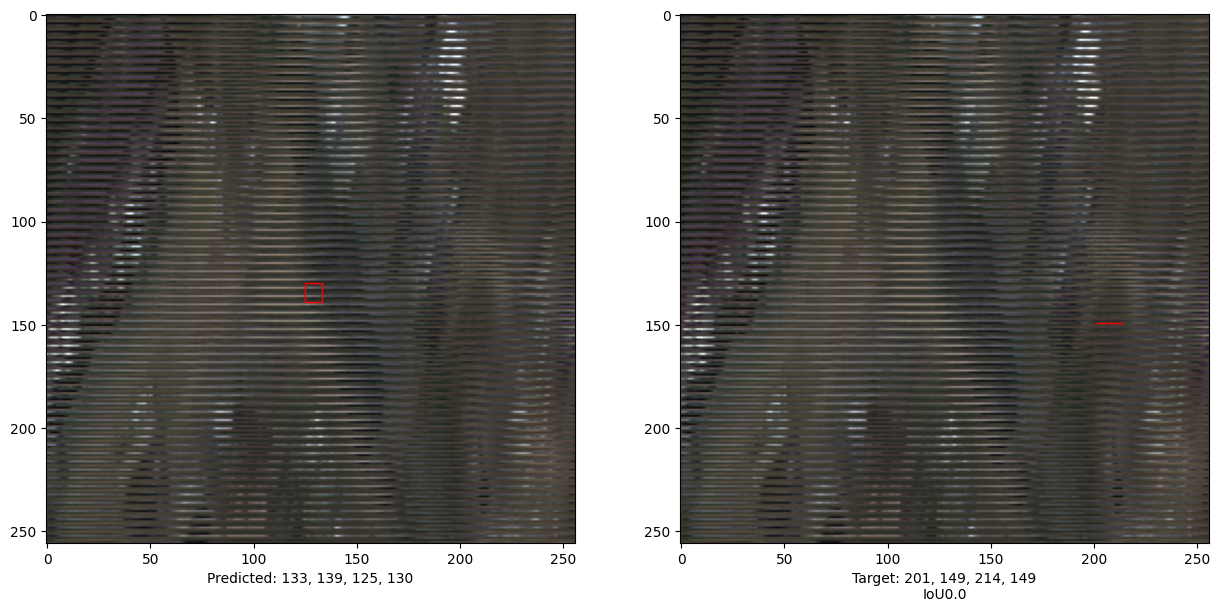

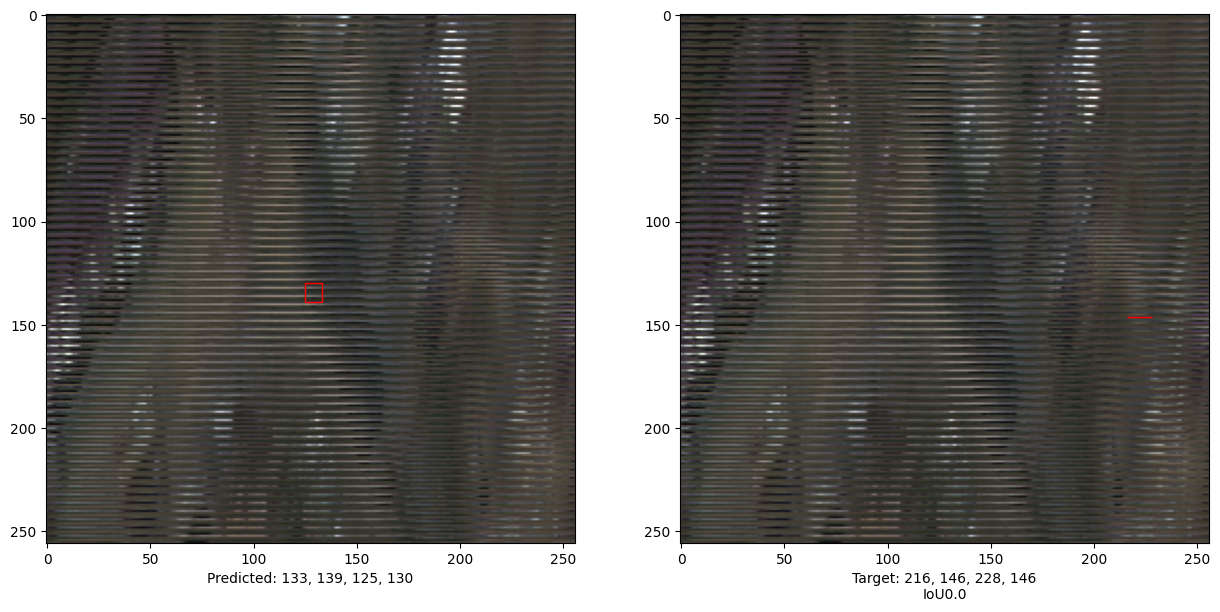

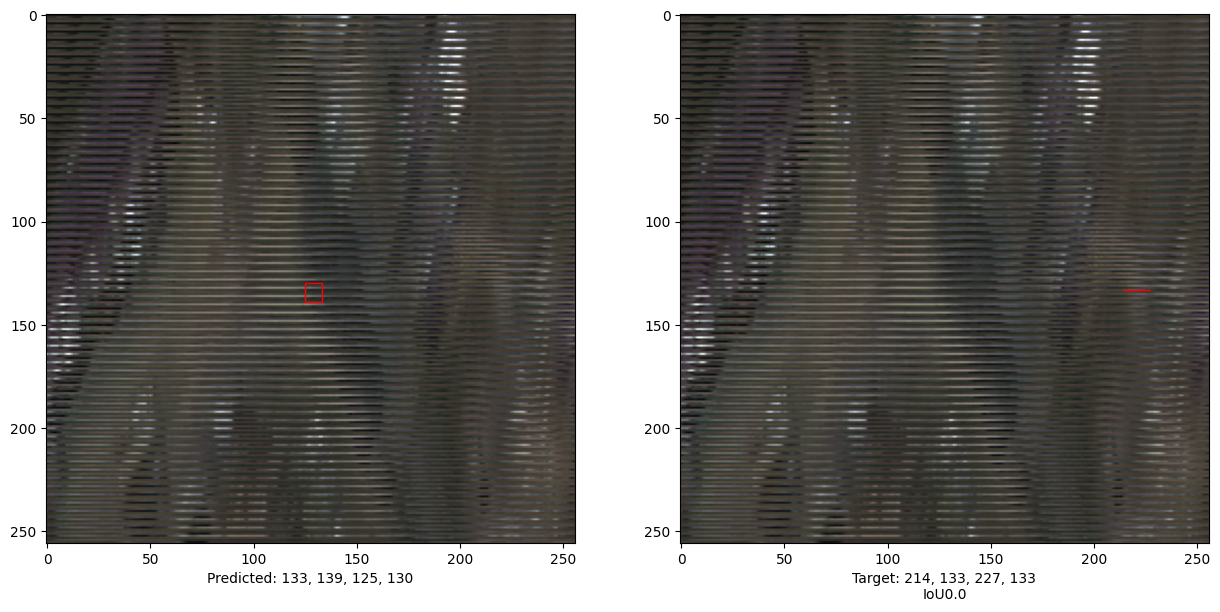

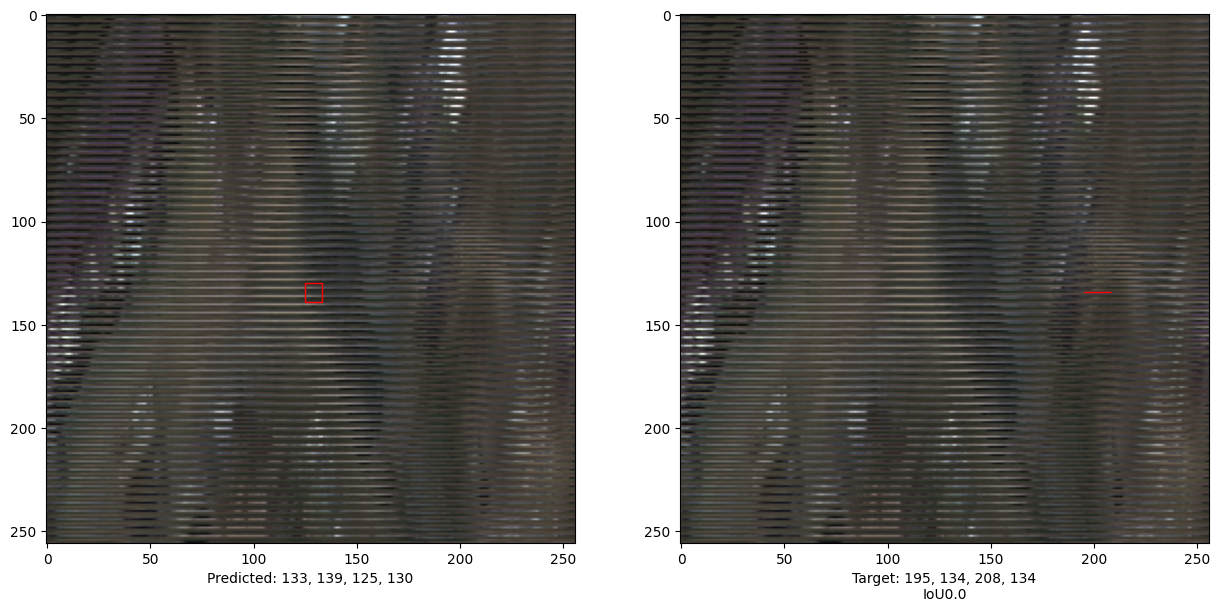

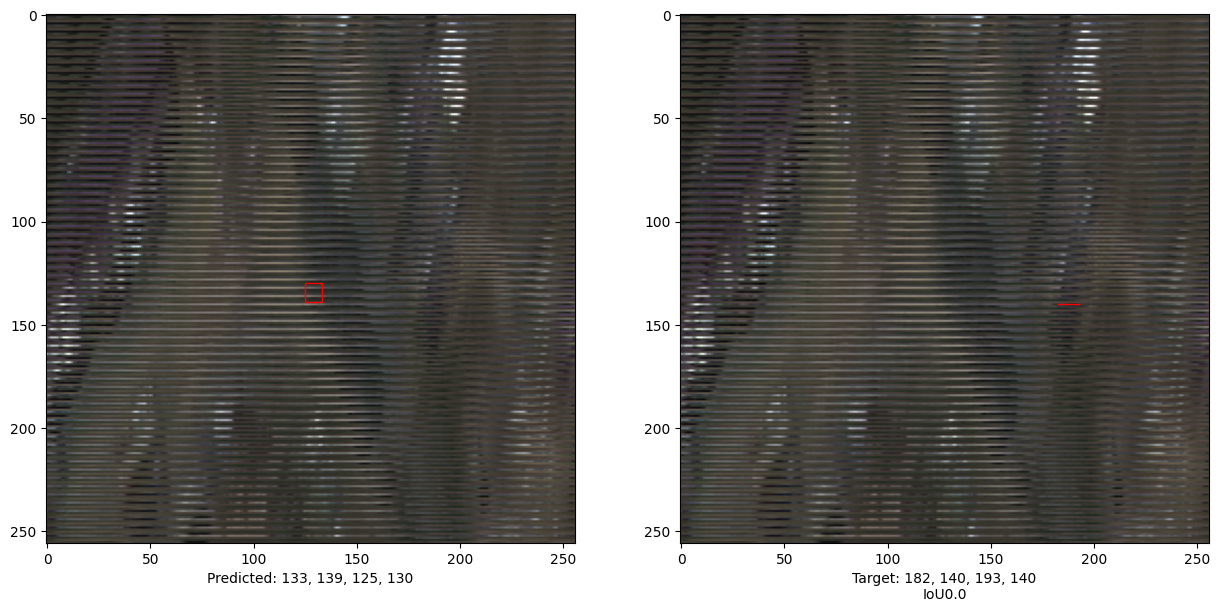

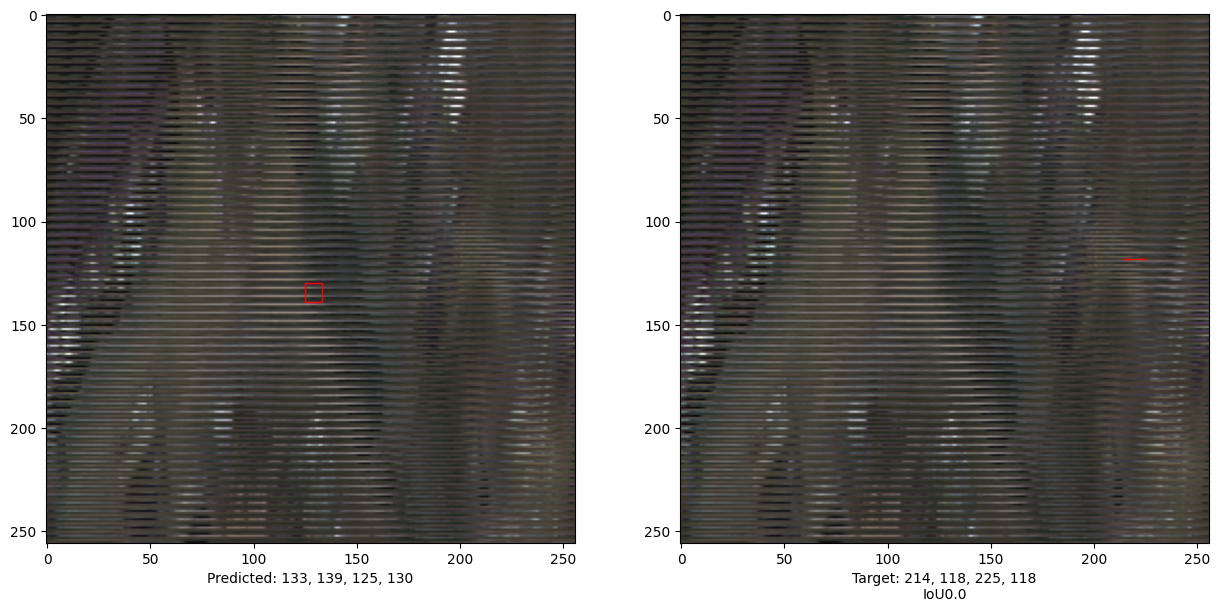

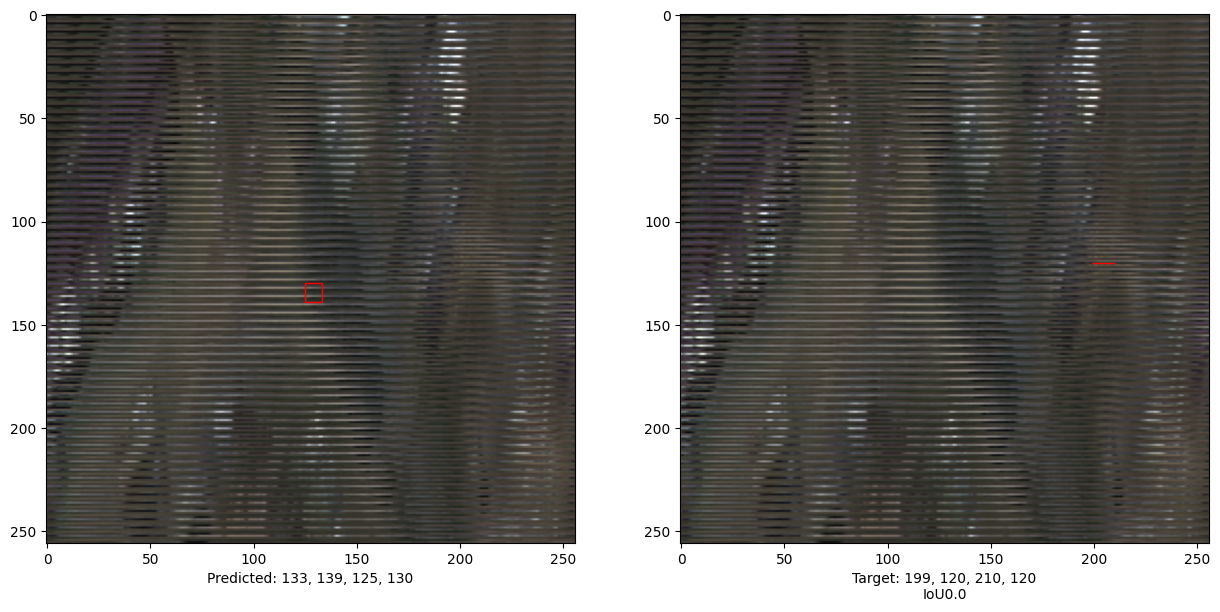

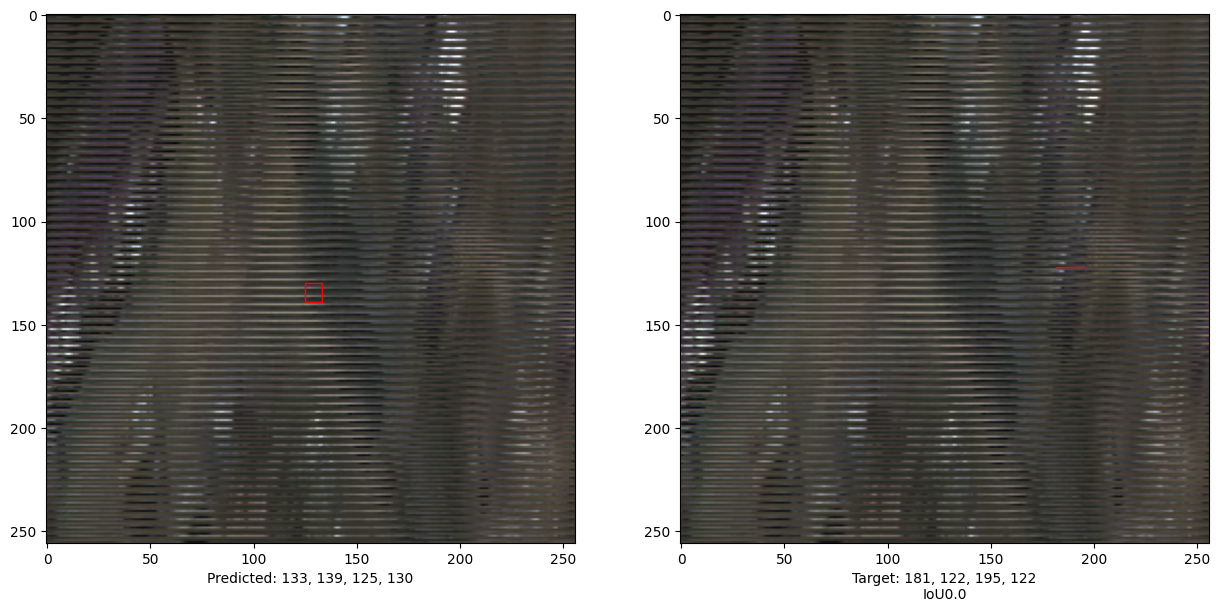

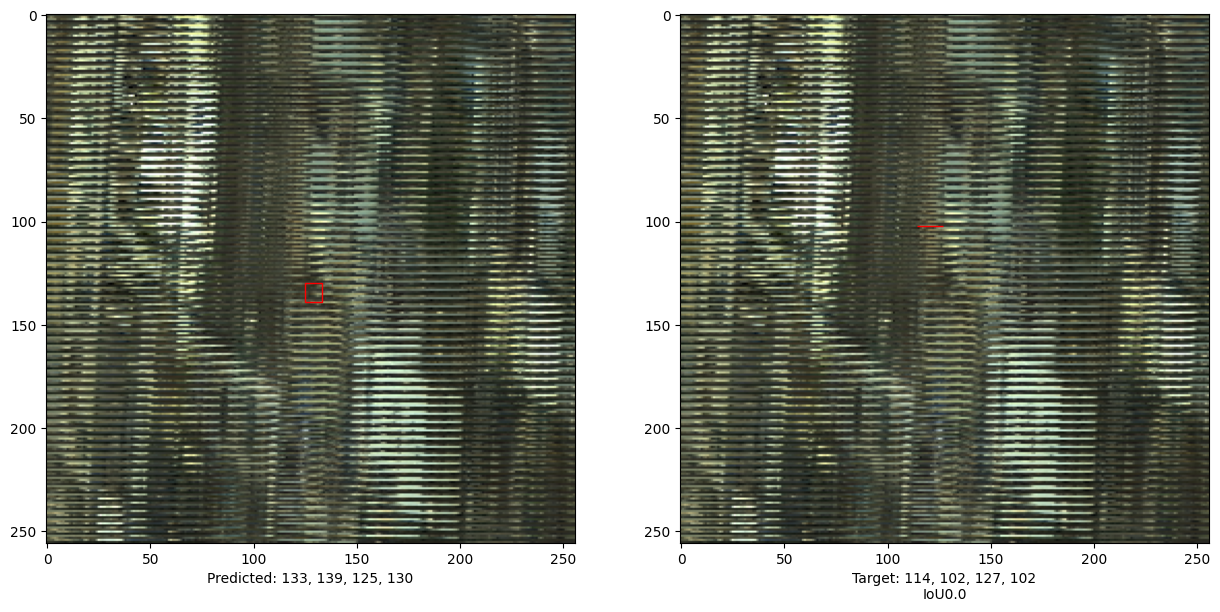

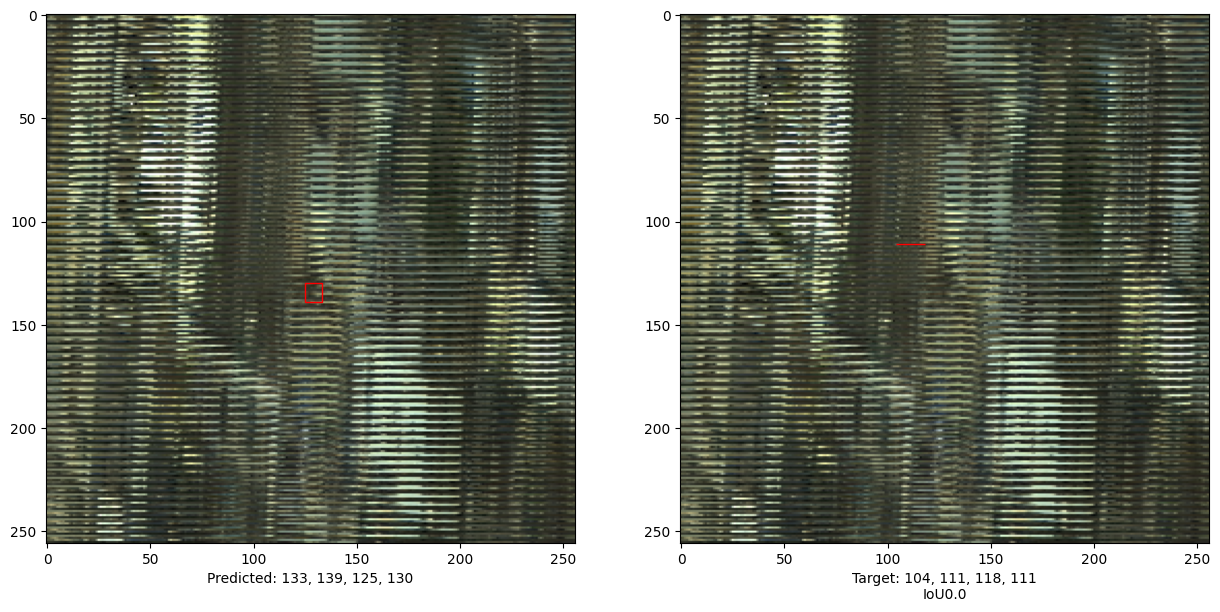

In [50]:
import matplotlib.patches as patches

# Saves the model in current path
vit_object_detector.save("vit_object_detector.h5", save_format="h5")

# To calculate IoU (intersection over union, given two bounding boxes)
def bounding_box_intersection_over_union(box_predicted, box_truth):
    # get (x, y) coordinates of intersection of bounding boxes
    top_x_intersect = max(box_predicted[0], box_truth[0])
    top_y_intersect = max(box_predicted[1], box_truth[1])
    bottom_x_intersect = min(box_predicted[2], box_truth[2])
    bottom_y_intersect = min(box_predicted[3], box_truth[3])

    # calculate area of the intersection bb (bounding box)
    intersection_area = max(0, bottom_x_intersect - top_x_intersect + 1) * max(
        0, bottom_y_intersect - top_y_intersect + 1
    )

    # calculate area of the prediction bb and ground-truth bb
    box_predicted_area = (box_predicted[2] - box_predicted[0] + 1) * (
        box_predicted[3] - box_predicted[1] + 1
    )
    box_truth_area = (box_truth[2] - box_truth[0] + 1) * (
        box_truth[3] - box_truth[1] + 1
    )

    # calculate intersection over union by taking intersection
    # area and dividing it by the sum of predicted bb and ground truth
    # bb areas subtracted by  the interesection area

    # return ioU
    return intersection_area / float(
        box_predicted_area + box_truth_area - intersection_area
    )


i, mean_iou = 0, 0

# Compare results for 10 images in the test set
for input_image in x_test[:10]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
    im = input_image

    # Display the image
    ax1.imshow(im.astype("uint8"))
    ax2.imshow(im.astype("uint8"))

    input_image = cv2.resize(
        input_image, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA
    )
    input_image = np.expand_dims(input_image, axis=0)
    preds = vit_object_detector.predict(input_image)[0]

    (h, w) = (256, 256)

    top_left_x, top_left_y = int(preds[4] * w), int(preds[5] * h)

    bottom_right_x, bottom_right_y = int(preds[0] * w), int(preds[1] * h)

    box_predicted = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
    # Create the bounding box
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    # Add the bounding box to the image
    ax1.add_patch(rect)
    ax1.set_xlabel(
        "Predicted: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
    )

    top_left_x, top_left_y = int(y_test[i][0] * w), int(y_test[i][1] * h)

    bottom_right_x, bottom_right_y = int(y_test[i][2] * w), int(y_test[i][3] * h)

    box_truth = top_left_x, top_left_y, bottom_right_x, bottom_right_y

    mean_iou += bounding_box_intersection_over_union(box_predicted, box_truth)
    # Create the bounding box
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    # Add the bounding box to the image
    ax2.add_patch(rect)
    ax2.set_xlabel(
        "Target: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
        + "\n"
        + "IoU"
        + str(bounding_box_intersection_over_union(box_predicted, box_truth))
    )
    i = i + 1

print("mean_iou: " + str(mean_iou / len(x_test[:10])))
plt.show()

### 결과 분석

- 상기의 그래프의 경우 모든 예측값이 동일한 것을 확인할 수 있음
- 이는 1장의 사진에 여러개의 정답을 매칭하다보니, 모든 정답에 가까울 확율이 높은 정중앙에 예측값이 수렴한 것으로 보임

### 해야할 일
- 1장의 사진에 여러개의 정답을 매칭하는 방법 찾기

In [49]:
###############################################
############### 필요 모듈 로드 #################
###############################################
 
import tensorflow
from tensorflow.keras.activations import gelu
import tensorflow_addons as tfa
from typing import List, Tuple
 
###############################################
############ 멀티 헤드 어텐션 정의 ##############
###############################################
 
class MultiHeadedAttention(tensorflow.keras.Model):
    def __init__(self, dimension: int, heads: int = 8):
        super(MultiHeadedAttention, self).__init__()
        self.heads = heads
        self.dimension = dimension
        assert dimension // heads
        self.depth = dimension // heads
        self.wq = tensorflow.keras.layers.Dense(dimension)
        self.wk = tensorflow.keras.layers.Dense(dimension)
        self.wv = tensorflow.keras.layers.Dense(dimension)
        self.dense = tensorflow.keras.layers.Dense(dimension)
 
    def call(self, inputs):
        output = None
        batch_size = tensorflow.shape(inputs)[0]
        q: tensorflow.Tensor = self.wq(inputs)
        k: tensorflow.Tensor = self.wk(inputs)
        v: tensorflow.Tensor = self.wv(inputs)
 
        def split_heads(x, batch_size):
            x = tensorflow.reshape(x, (batch_size, -1, self.heads, self.depth))
            return tensorflow.transpose(x, perm=[0,2,1,3])
 
        q = split_heads(q, batch_size)
        k = split_heads(k, batch_size)
        v = split_heads(v, batch_size)
 
        def scaled_dot_product_attention(q,k,v):
            matmul_qk = tensorflow.matmul(q, k, transpose_b = True)
            dk = tensorflow.cast(tensorflow.shape(k)[-1], tensorflow.float32)
            scaled_attention_logits = matmul_qk / tensorflow.math.sqrt(dk)
 
            softmax = tensorflow.nn.softmax(scaled_attention_logits, axis=-1)
            scaled_dot_product_attention_output = tensorflow.matmul(softmax, v)
            return scaled_dot_product_attention_output, softmax
        
        attention_weights, softmax = scaled_dot_product_attention(q, k, v)
        scaled_attention = tensorflow.transpose(attention_weights, perm=[0,2,1,3])
        concat_attention = tensorflow.reshape(scaled_attention, (batch_size, -1, self.dimension))
        output = self.dense(concat_attention)
        return output
 
###############################################
############ 레지듀얼 블록 정의 ################
###############################################
 
class ResidualBlock(tensorflow.keras.Model):
    def __init__(self, residual_function):
        super(ResidualBlock, self).__init__()
        self.residual_function = residual_function
 
    def call(self, inputs):
        return self.residual_function(inputs) + inputs
 
###############################################
######## LayerNormalization 정의 ##############
###############################################
 
class NormalizationBlock(tensorflow.keras.Model):
    def __init__(self, norm_function, epsilon=1e-5):
        super(NormalizationBlock, self).__init__()
        self.norm_function = norm_function
        self.normalize = tensorflow.keras.layers.LayerNormalization(epsilon=1e-6)
 
    def call(self, inputs):
        return self.norm_function(self.normalize(inputs))
 
###############################################
############### MLP 블록 정의 #################
###############################################
 
class MLPBlock(tensorflow.keras.Model):
    def __init__(self, output_dimension, hidden_dimension):
        super(MLPBlock, self).__init__()
        self.output_dimension = tensorflow.keras.layers.Dense(output_dimension)
        self.hidden_dimension = tensorflow.keras.layers.Dense(hidden_dimension)
        self.dropout1 = tensorflow.keras.layers.Dropout(0.1)
        self.dropout2 = tensorflow.keras.layers.Dropout(0.1)
 
    def call(self, inputs):
        output = None
        x = self.hidden_dimension(inputs)
        x = gelu(x)
        x = self.dropout1(x)
        x = self.output_dimension(x)
        x = gelu(x)
        output = self.dropout2(x)
        return output
 
 
 
###############################################
############ 트랜스포머 인코더 정의 #############
###############################################
 
class TransformerEncoder(tensorflow.keras.layers.Layer):
    def __init__(self, dimension, depth, heads, mlp_dimension): 
        super(TransformerEncoder, self).__init__()
        layers_ = []
        layers_.append(tensorflow.keras.Input(shape=((CFG.obj_image_size//CFG.patch_size)*(CFG.obj_image_size//CFG.patch_size)+1,dimension)))
        for i in range(depth):
            layers_.append(NormalizationBlock(ResidualBlock(MultiHeadedAttention(dimension, heads))))
            layers_.append(NormalizationBlock(ResidualBlock(MLPBlock(dimension, mlp_dimension))))
        
        self.layers_ = tensorflow.keras.Sequential(layers_)
 
    def call(self, inputs):
        return self.layers_(inputs)
 
###############################################
############### VIT 전체 구현 #################
###############################################
 
class ImageTransformer(tensorflow.keras.Model):
    def __init__(
            self, image_size, patch_size, n_classes, batch_size,
            dimension, depth, heads, mlp_dimension, channels=3):
        super(ImageTransformer, self).__init__()
        assert image_size % patch_size == 0, 'invalid patch size for image size'
 
        num_patches = (image_size // patch_size) ** 2
        self.patch_size = patch_size
        self.dimension = dimension
        self.batch_size = batch_size
 
        self.positional_embedding = self.add_weight(
            "position_embeddings", shape=[num_patches + 1, dimension],
            initializer=tensorflow.keras.initializers.RandomNormal(), dtype=tensorflow.float32
        )
        self.classification_token = self.add_weight(
            "classification_token", shape=[1, 1, dimension],
            initializer=tensorflow.keras.initializers.RandomNormal(), dtype=tensorflow.float32
        )
        self.heads = heads
        self.depth = depth
        self.mlp_dimension = dimension
        self.n_classes = n_classes
        self.num_patches = num_patches
 
        self.patch_projection = tensorflow.keras.layers.Dense(dimension)
        self.normalization2 = tensorflow.keras.layers.LayerNormalization(epsilon=1e-6)
        self.MLP = MLPBlock(self.dimension, self.mlp_dimension)
        self.output_classes = tensorflow.keras.layers.Dense(self.n_classes)
        self.transformer = TransformerEncoder(self.dimension, self.depth, self.heads, self.mlp_dimension)
        self.dropout1 = tensorflow.keras.layers.Dropout(0.5)
 
    def call(self, inputs):       
        output = None
        batch_size = tensorflow.shape(inputs)[0]
        
        ###############################################
        ############ 가장 중요한 부분 ##################
        ###############################################
 
        # 이미지를 patch_size로 조각낸다.
        patches = tensorflow.image.extract_patches(
            images = inputs,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1,1,1,1],
            padding="VALID",
        )
 
        patch_dims = patches.shape[-1]
        patches = tensorflow.reshape(patches, [batch_size, patches.shape[1]*patches.shape[2], patch_dims])
        x = self.patch_projection(patches)
        
        cls_pos = tensorflow.broadcast_to(
            self.classification_token, [batch_size, 1, self.dimension]
        )
        x = tensorflow.concat([cls_pos, x], axis=1)
        x = x + self.positional_embedding
        x = self.transformer(x)
        x = self.normalization2(x)
        x = x[:,0,:]
        x_keep = tensorflow.identity(x)
        x = self.dropout1(x)
        output = self.output_classes(x)
        return output
 
 
# from tensorflow.keras import datasets
# # CIFAR10 데이터 다운로드
# (train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
# train_images = train_images / 255.
# test_images = test_images / 255.
 
class CFG:
    num_classes = 1
    input_shape = (256, 256, 3)
    learning_rate = 0.001
    weight_decay = 0.0001
    batch_size = 256
    num_epochs = 100
    image_size = 32
    obj_image_size = 32
    patch_size = 4
    num_patches = (IMAGE_SIZE // patch_size) ** 2
    projection_dim = 64
    num_heads = 8
    transformer_layers = 2
 
CFG = CFG()
optimizer = tfa.optimizers.AdamW(learning_rate = CFG.learning_rate, weight_decay=CFG.weight_decay)
 
model_vit = ImageTransformer(CFG.image_size, CFG.patch_size, CFG.num_classes, CFG.batch_size, CFG.projection_dim, CFG.transformer_layers, CFG.num_heads, CFG.projection_dim)
model_vit.compile(
        optimizer=optimizer,
        loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tensorflow.keras.metrics.SparseCategoricalAccuracy(name="accuracy")])
 
model_vit.fit(x=x_train, y=y_train, batch_size=CFG.batch_size, epochs=CFG.num_epochs, validation_data=(x_test, y_test), shuffle=True)
print('==============Training Finished===============')
 
accuracy = 0
_, accuracy = model_vit.evaluate(x_test, y_test)
 
print('Test Accuracy :', accuracy)


Epoch 1/100


ValueError: in user code:

    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/__autograph_generated_file3p90z5yf.py", line 18, in tf__call
        x = (ag__.ld(x) + ag__.ld(self).positional_embedding)

    ValueError: Exception encountered when calling layer 'image_transformer_2' (type ImageTransformer).
    
    in user code:
    
        File "<ipython-input-49-6ccf5055a2fe>", line 185, in call  *
            x = x + self.positional_embedding
    
        ValueError: Dimensions must be equal, but are 4097 and 65 for '{{node image_transformer_2/add}} = AddV2[T=DT_FLOAT](image_transformer_2/concat, image_transformer_2/add/ReadVariableOp)' with input shapes: [?,4097,64], [65,64].
    
    
    Call arguments received by layer 'image_transformer_2' (type ImageTransformer):
      • inputs=tf.Tensor(shape=(None, 256, 256, 3), dtype=float32)
